In [1]:
# Initial imports
import os # Miscellaneous operating system interfaces (os.getenv)
import requests # requests.get
import pandas as pd
from dotenv import load_dotenv #Reads the key-value pair from .env file and adds them to environment variable.
from pathlib import Path
import json # lightweight data interchange format 
import matplotlib.pyplot as plt
import FundamentalAnalysis as fa
import alpaca_trade_api as tradeapi
import panel as pn
import plotly.express as px
import hvplot.pandas
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
from panel.interact import interact
from panel import widgets

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\Khemero\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Prepare Data

In [2]:
# Load .env enviroment variables
load_dotenv()
env_path = Path('C:/Users/Khemero/.env')

In [3]:
# Set Fundamental Analysis API key
fa_api_key = os.getenv("FINANCIAL_MODELING_PREP_API_KEY")

In [4]:
# Confirm API correctly set
type(fa_api_key)

str

In [5]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [6]:
# Set the file path for S&P 500 data sources
sp_data = Path("Resources/sp.csv")
sp_symbols_data = Path("Resources/sp500_symbols.csv")
sp_ticker_data = Path("Resources/sp500_ticker.csv")

In [7]:
# Read SP 500 data CSV files and set the `date` column as a datetime index to the DataFrame
sp_df = pd.read_csv(sp_data, index_col="Date", infer_datetime_format=True, parse_dates=True)
sp_df.sort_index(ascending = True, inplace = True)

sp_symbols = pd.read_csv(sp_symbols_data, index_col="Symbol", infer_datetime_format=True, parse_dates=True)
sp_symbols.sort_index(ascending = True, inplace = True)

sp_ticker = pd.read_csv(sp_ticker_data, index_col="Symbol", infer_datetime_format=True, parse_dates=True)
sp_ticker.sort_index(ascending = True, inplace = True)

sp_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02 16:00:00,2476.96,2519.49,2467.47,2510.03,2233765369
2019-01-03 16:00:00,2491.92,2493.14,2443.96,2447.89,2754752741
2019-01-04 16:00:00,2474.33,2538.07,2474.33,2531.94,2661709794
2019-01-07 16:00:00,2535.61,2566.16,2524.56,2549.69,2526552370
2019-01-08 16:00:00,2568.11,2579.82,2547.56,2574.41,2458286256


In [8]:
# Drop nulls and confirm
sp_df = sp_df.dropna().copy()

sp_df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [9]:
# Drop duplicates and confirm
sp_df = sp_df.drop_duplicates().copy()

sp_df.duplicated().sum()

0

In [10]:
# Add the "SP 500" column index and check
index_columns = [("SP 500", "open"), ("SP 500", "high"), ("SP 500", "low"), ("SP 500", "close"), ("SP 500", "volume")]
sp_df.columns = pd.MultiIndex.from_tuples(index_columns)
sp_df.head()

SP 500                                       
                        open     high      low    close      volume
Date                                                               
2019-01-02 16:00:00  2476.96  2519.49  2467.47  2510.03  2233765369
2019-01-03 16:00:00  2491.92  2493.14  2443.96  2447.89  2754752741
2019-01-04 16:00:00  2474.33  2538.07  2474.33  2531.94  2661709794
2019-01-07 16:00:00  2535.61  2566.16  2524.56  2549.69  2526552370
2019-01-08 16:00:00  2568.11  2579.82  2547.56  2574.41  2458286256

In [11]:
# Remove time stamp from DateIndex and check
sp = sp_df.reset_index()
sp["Date"] = sp["Date"].astype(str).str[:-8]
sp_500_data_df = sp.set_index("Date")

In [12]:
sp_500_data_df.head()

SP 500                                       
                open     high      low    close      volume
Date                                                       
2019-01-02   2476.96  2519.49  2467.47  2510.03  2233765369
2019-01-03   2491.92  2493.14  2443.96  2447.89  2754752741
2019-01-04   2474.33  2538.07  2474.33  2531.94  2661709794
2019-01-07   2535.61  2566.16  2524.56  2549.69  2526552370
2019-01-08   2568.11  2579.82  2547.56  2574.41  2458286256

In [13]:
# Calculate daily percentage change for SP 500 stocks
sp_500_daily_change_df = sp_500_data_df.pct_change()
sp_500_daily_change_df.head()

SP 500                                        
                 open      high       low     close    volume
Date                                                         
2019-01-02        NaN       NaN       NaN       NaN       NaN
2019-01-03   0.006040 -0.010458 -0.009528 -0.024757  0.233233
2019-01-04  -0.007059  0.018021  0.012427  0.034336 -0.033775
2019-01-07   0.024766  0.011067  0.020300  0.007010 -0.050778
2019-01-08   0.012817  0.005323  0.009110  0.009695 -0.027019

In [14]:
# Get top 10 foreign stocks purchased by Aussies from Jan 2019 to Dec 2020

# Format current date as ISO format
today = pd.Timestamp("2020-12-24", tz="America/New_York").isoformat() 
start_date = pd.Timestamp("2019-01-01", tz="America/New_York").isoformat()   
end_date = pd.Timestamp("2020-12-31", tz="America/New_York").isoformat()   

# Set the tickers for most foreign stocks purchased by Aussies
tickers = ["TSLA", "AAPL", "PFE", "MSFT", "MRNA", "NIO", "AMZN", "NNDM", "CRM", "NVDA"]

#Set variables
dict = {'stock':'', 'segment':''}  
marketcaps = {}
segments = {}
for stock in tickers:
    profile = fa.profile(stock, fa_api_key) 
    try: 
        marketcaps[stock] = int(profile.iloc[22])
        segment = str(profile.iloc[26])[5:]
        segments[stock] = segment[:-28]
    except: continue
    
# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get 2-year daily data for most foreign stocks purchased by Aussies
foreign_stocks_df = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

In [15]:
# Adjust date and time format to match SP 500 data. Remove timezome and time stamp

top_10 = foreign_stocks_df.reset_index().rename(columns={"time" : "Date"}) 
top_10["Date"] = top_10["Date"].astype(str).str[:-14]
foreign_stock_data_df = top_10.set_index("Date")

foreign_stock_data_df.head()

AAPL                                           AMZN           \
               open      high     low     close    volume     open     high   
Date                                                                          
2019-01-02   154.89  158.8500  154.23  157.5225  27803621  1465.20  1553.36   
2019-01-03   143.98  145.7200  142.00  142.2900  82418448  1520.01  1538.00   
2019-01-04   144.53  148.5499  143.80  148.1200  51267225  1530.00  1594.00   
2019-01-07   148.70  148.8300  145.90  147.9100  49982480  1602.31  1634.56   
2019-01-08   149.56  151.8200  148.52  150.6300  36592406  1664.69  1676.61   

                                           ...    PFE                  \
                   low     close   volume  ...   open    high     low   
Date                                       ...                          
2019-01-02   1460.9300  1536.730  7132821  ...  43.12  43.500  42.635   
2019-01-03   1498.1062  1502.070  6340704  ...  43.24  43.340  42.050   
2019-01-04   1518.3100  1574.540  8285596  ...  42.44  43.345  42.255   
2019-01-07   1589.1850  1631.120  7252880  ...  43.07  43.620  42.860   
2019-01-08   1616.6100  1655.835  8184304  ...  43.56  43.700  43.150   

                                  TSLA                                        
               close    volume    open    high       low     close    volume  
Date                                                                          
2019-01-02   43.2399  18955059  306.50  315.13  298.8000  309.8699  10751296  
2019-01-03   42.1200  21019824  307.00  309.40  297.3800  300.3100   6672221  
2019-01-04   43.0350  19239018  306.00  318.00  302.7300  317.5400   6983846  
2019-01-07   43.3050  15177806  321.66  336.74  317.7508  334.9860   7193888  
2019-01-08   43.4100  15293321  341.98  344.01  327.0200  335.4900   6567180  

[5 rows x 50 columns]

In [16]:
# Calculate daily percentage change for most foreign stocks purchased by Aussies
foreign_stocks_daily_change_df = foreign_stock_data_df.pct_change()
foreign_stocks_daily_change_df.head()

AAPL                                              AMZN  \
                 open      high       low     close    volume      open   
Date                                                                      
2019-01-02        NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-03  -0.070437 -0.082657 -0.079297 -0.096700  1.964306  0.037408   
2019-01-04   0.003820  0.019420  0.012676  0.040973 -0.377964  0.006572   
2019-01-07   0.028852  0.001886  0.014604 -0.001418 -0.025060  0.047261   
2019-01-08   0.005783  0.020090  0.017958  0.018390 -0.267895  0.038931   

                                                     ...       PFE            \
                 high       low     close    volume  ...      open      high   
Date                                                 ...                       
2019-01-02        NaN       NaN       NaN       NaN  ...       NaN       NaN   
2019-01-03  -0.009888  0.025447 -0.022554 -0.111052  ...  0.002783 -0.003678   
2019-01-04   0.036411  0.013486  0.048247  0.306731  ... -0.018501  0.000115   
2019-01-07   0.025445  0.046680  0.035934 -0.124640  ...  0.014844  0.006344   
2019-01-08   0.025726  0.017257  0.015152  0.128421  ...  0.011377  0.001834   

                                               TSLA                      \
                  low     close    volume      open      high       low   
Date                                                                      
2019-01-02        NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-03  -0.013721 -0.025900  0.108929  0.001631 -0.018183 -0.004752   
2019-01-04   0.004875  0.021724 -0.084720 -0.003257  0.027796  0.017990   
2019-01-07   0.014318  0.006274 -0.211092  0.051176  0.058931  0.049618   
2019-01-08   0.006766  0.002425  0.007611  0.063172  0.021589  0.029171   

                                 
                close    volume  
Date                             
2019-01-02        NaN       NaN  
2019-01-03  -0.030851 -0.379403  
2019-01-04   0.057374  0.046705  
2019-01-07   0.054941  0.030075  
2019-01-08   0.001505 -0.087117  

[5 rows x 50 columns]

In [17]:
# Join 2-Year SP 500 data returns to that of foreign stock mostly purchased by Aussies
combined_data_daily_change_df = pd.concat([foreign_stocks_daily_change_df, sp_500_daily_change_df], axis = "columns", join = "inner")
combined_data_daily_change_df.head()

AAPL                                              AMZN  \
                 open      high       low     close    volume      open   
Date                                                                      
2019-01-02        NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-03  -0.070437 -0.082657 -0.079297 -0.096700  1.964306  0.037408   
2019-01-04   0.003820  0.019420  0.012676  0.040973 -0.377964  0.006572   
2019-01-07   0.028852  0.001886  0.014604 -0.001418 -0.025060  0.047261   
2019-01-08   0.005783  0.020090  0.017958  0.018390 -0.267895  0.038931   

                                                     ...      TSLA            \
                 high       low     close    volume  ...      open      high   
Date                                                 ...                       
2019-01-02        NaN       NaN       NaN       NaN  ...       NaN       NaN   
2019-01-03  -0.009888  0.025447 -0.022554 -0.111052  ...  0.001631 -0.018183   
2019-01-04   0.036411  0.013486  0.048247  0.306731  ... -0.003257  0.027796   
2019-01-07   0.025445  0.046680  0.035934 -0.124640  ...  0.051176  0.058931   
2019-01-08   0.025726  0.017257  0.015152  0.128421  ...  0.063172  0.021589   

                                             SP 500                      \
                  low     close    volume      open      high       low   
Date                                                                      
2019-01-02        NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-03  -0.004752 -0.030851 -0.379403  0.006040 -0.010458 -0.009528   
2019-01-04   0.017990  0.057374  0.046705 -0.007059  0.018021  0.012427   
2019-01-07   0.049618  0.054941  0.030075  0.024766  0.011067  0.020300   
2019-01-08   0.029171  0.001505 -0.087117  0.012817  0.005323  0.009110   

                                 
                close    volume  
Date                             
2019-01-02        NaN       NaN  
2019-01-03  -0.024757  0.233233  
2019-01-04   0.034336 -0.033775  
2019-01-07   0.007010 -0.050778  
2019-01-08   0.009695 -0.027019  

[5 rows x 55 columns]

In [18]:
# Select daily closing returns for all stocks and the index
combined_df = combined_data_daily_change_df.xs("close", axis=1, level=1, drop_level=True)
combined_df.head()

,AAPL,AMZN,CRM,MRNA,MSFT,NIO,NNDM,NVDA,PFE,TSLA,SP 500
Date,,,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.096700,-0.022554,-0.035701,0.014388,-0.034749,-0.024174,0.000000,-0.056103,-0.025900,-0.030851,-0.024757
2019-01-04,0.040973,0.048247,0.056646,0.094455,0.043846,0.047069,0.024390,0.058269,0.021724,0.057374,0.034336
2019-01-07,-0.001418,0.035934,0.031483,-0.036819,0.003685,0.025237,-0.047619,0.057122,0.006274,0.054941,0.007010
2019-01-08,0.018390,0.015152,0.025459,0.036697,0.005678,-0.015538,0.008333,-0.027923,0.002425,0.001505,0.009695


In [19]:
# Determine market capitalization and segments of top 10 foreign stocks purchased by Aussies
marketcaps_df = pd.DataFrame(marketcaps.items(), columns=['stock', 'marketcap'])
segments_df = pd.DataFrame(segments.items(), columns=['stock', 'marketcap']).rename(columns={
    "marketcap":"sector"
})

In [20]:
marketcaps_df

,stock,marketcap
0,TSLA,668905310000
1,AAPL,2255968800000
2,PFE,204604719000
3,MSFT,1681606440000
4,MRNA,41339826000
5,NIO,75981275000
6,AMZN,1634167820000
7,NNDM,1261523840
8,CRM,204223349000
9,NVDA,323241804000


In [21]:
segments_df

,stock,sector
0,TSLA,Consumer Cyclical
1,AAPL,Technology
2,PFE,Healthcare
3,MSFT,Technology
4,MRNA,Healthcare
5,NIO,Consumer Cyclical
6,AMZN,Consumer Cyclical
7,NNDM,Technology
8,CRM,Technology
9,NVDA,Technology


In [22]:
# Drop columns
segments = segments_df.drop(columns=[
    "stock", 
])

In [23]:
# Create dataframe showing market capitalization and sectors for top 10 foreign stocks purchased by Aussies
joined_df = pd.concat([marketcaps_df, segments], axis="columns", join="inner")
joined_df.head()

,stock,marketcap,sector
0,TSLA,668905310000,Consumer Cyclical
1,AAPL,2255968800000,Technology
2,PFE,204604719000,Healthcare
3,MSFT,1681606440000,Technology
4,MRNA,41339826000,Healthcare


In [24]:
# Create dataframe showing decription of SP 500 stocks  
joined_symbol_df = pd.concat([sp_symbols, sp_ticker], axis="columns", join="inner")
joined_symbol_df.head()

,#,Company,Weight,Price,Chg,% Chg,Security,GICS Sector,GICS Sub-Industry,Founded
Symbol,,,,,,,,,,
A,167,Agilent Technologies Inc.,0.119286,119.3,0.33,-0.28%,Agilent Technologies Inc,Health Care,Health Care Equipment,1999
AAL,446,American Airlines Group Inc.,0.027919,16.74,-0.06,(-0.36%),American Airlines Group,Industrials,Airlines,1934
AAP,417,Advance Auto Parts Inc.,0.035977,159.99,-0.35,(-0.22%),Advance Auto Parts,Consumer Discretionary,Automotive Retail,1932
AAPL,1,Apple Inc.,6.700995,127.3,-1.40,(-1.09%),Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",1977
ABBV,33,AbbVie Inc.,0.600080,104.45,-0.44,(-0.42%),AbbVie Inc.,Health Care,Pharmaceuticals,2013


# Quantitative Analyses

In [25]:
### Calculate Performance Metrics for 2-year window
# Correlation - Is there value for this metric?
# Cumulative returns
# Standard deviaton
# Beta comparison
# Sharpe Ratio
# Treynor Ratio - same equation as Sharpe Ratio but substitutes SD with beta

In [26]:
# Calculate the correlation
daily_returns = combined_df
correlation = combined_df.corr()
# Display the correlation matrix
correlation

# no negative correlations unfortunately

,AAPL,AMZN,CRM,MRNA,MSFT,NIO,NNDM,NVDA,PFE,TSLA,SP 500
AAPL,1.000000,0.368854,0.332710,0.070404,0.497628,0.116972,0.011287,0.409446,0.273073,0.699962,0.477904
AMZN,0.368854,1.000000,0.571752,0.059603,0.725110,0.227041,0.000605,0.634680,0.318094,0.321479,0.614077
CRM,0.332710,0.571752,1.000000,0.076626,0.705048,0.220001,0.024511,0.583037,0.338096,0.355660,0.670200
MRNA,0.070404,0.059603,0.076626,1.000000,0.077473,0.063812,-0.009295,0.104214,0.160852,0.062562,0.055963
MSFT,0.497628,0.725110,0.705048,0.077473,1.000000,0.209299,-0.000919,0.762144,0.518046,0.391659,0.868389
NIO,0.116972,0.227041,0.220001,0.063812,0.209299,1.000000,-0.039808,0.221177,0.056044,0.207121,0.232713
NNDM,0.011287,0.000605,0.024511,-0.009295,-0.000919,-0.039808,1.000000,0.026563,0.009619,0.028353,0.016300
NVDA,0.409446,0.634680,0.583037,0.104214,0.762144,0.221177,0.026563,1.000000,0.395092,0.363931,0.746150
PFE,0.273073,0.318094,0.338096,0.160852,0.518046,0.056044,0.009619,0.395092,1.000000,0.130935,0.627243
TSLA,0.699962,0.321479,0.355660,0.062562,0.391659,0.207121,0.028353,0.363931,0.130935,1.000000,0.364227


Text(0, 0.5, 'Daily Change')

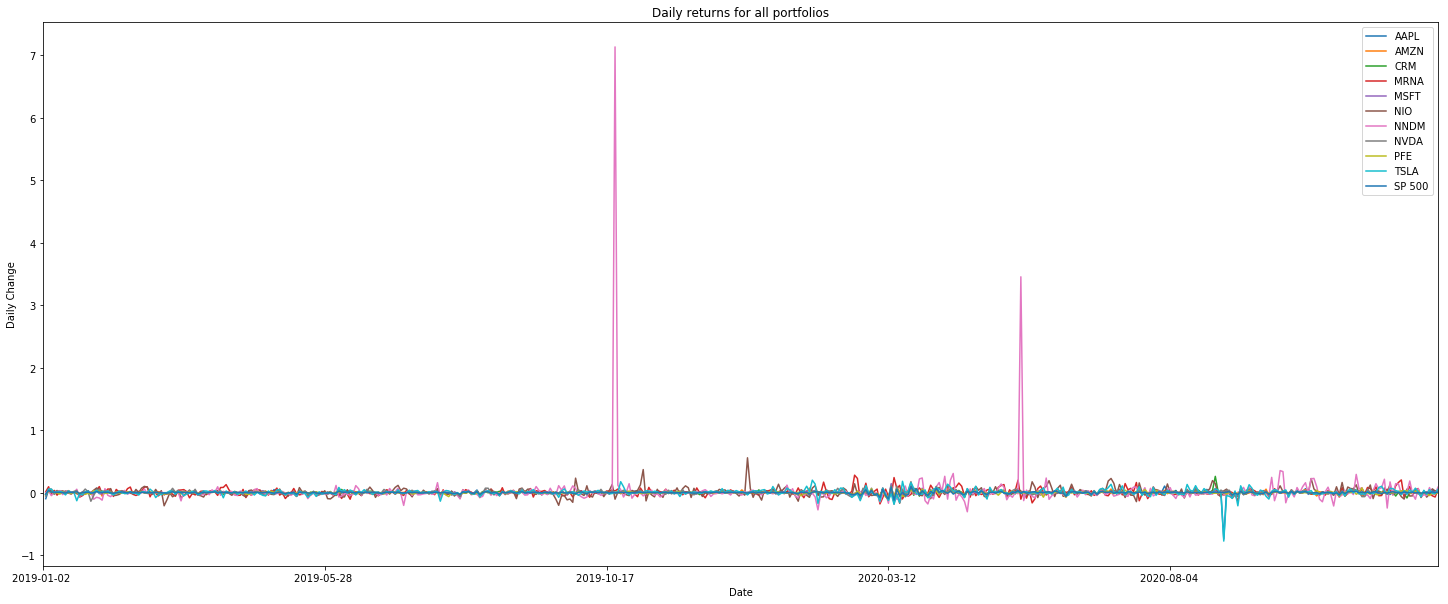

In [27]:
# Plot daily returns of all stocks
combined_df.plot(figsize=(25,10), title='Daily returns for all portfolios') 
plt.xlabel('Date')
plt.ylabel('Daily Change')

In [28]:
# Calculate cumulative returns of all portfolios
cumulative_returns = (1 + combined_df).cumprod()

# Plot cumulative returns
cumulative_returns.hvplot.line(xticks=15, width=1000, height=500, legend='top_left', xlabel = 'Date', ylabel = 'value' ).opts(axiswise=True)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

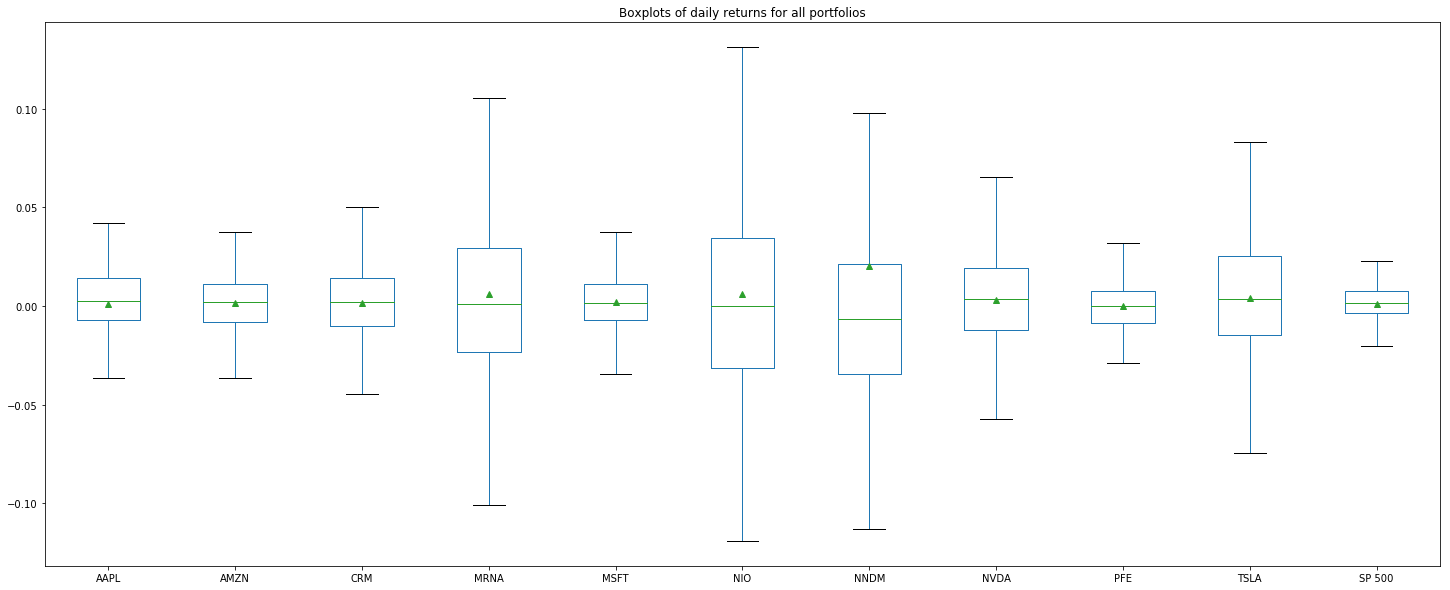

In [29]:
# Box plot to visually show risk
combined_df.plot.box(figsize=(25,10), showmeans=True, showfliers=False, title='Boxplots of daily returns for all portfolios') 

# I hid the outliers/special causes as they require investigation, a one way anova would show a true secret sauce to trading with a difference

In [30]:
# Calculate the daily standard deviations of all portfolios
combined_df_std = combined_df.std().sort_values(ascending=False)
combined_df_std

NNDM      0.363170
NIO       0.066554
TSLA      0.057405
MRNA      0.052722
AAPL      0.041153
NVDA      0.031844
CRM       0.026379
MSFT      0.021704
AMZN      0.020185
PFE       0.018245
SP 500    0.016463
dtype: float64

In [31]:
# Determine which portfolios are riskier than the S&P TSX 60
## This will compare the portfolio against S&P TSX 60 for the same date range.
riskier_than_SP = combined_df_std > combined_df_std.loc['SP 500']
print(f'The below shows which portfolios are riskier than the S&P TSX 60 for the same date range')
print(f'{riskier_than_SP}')

The below shows which portfolios are riskier than the S&P TSX 60 for the same date range
NNDM       True
NIO        True
TSLA       True
MRNA       True
AAPL       True
NVDA       True
CRM        True
MSFT       True
AMZN       True
PFE        True
SP 500    False
dtype: bool


In [32]:
# Calculate the annualized standard deviation (252 trading days)
annualized_std = combined_df.std() * np.sqrt(252)
annualized_std.sort_values(ascending=False)

NNDM      5.765143
NIO       1.056516
TSLA      0.911284
MRNA      0.836930
AAPL      0.653277
NVDA      0.505502
CRM       0.418750
MSFT      0.344533
AMZN      0.320419
PFE       0.289631
SP 500    0.261337
dtype: float64

In [33]:
# Annualized Sharpe Ratios
daily_returns = combined_df
sharpe_ratio = (daily_returns.mean() * 252 / (daily_returns.std() * np.sqrt(252)))
sharpe_ratio.sort_values(ascending=False)

MRNA      1.772341
NVDA      1.632567
NIO       1.463516
AMZN      1.344165
MSFT      1.319462
TSLA      1.107401
SP 500    0.899576
NNDM      0.880962
CRM       0.828436
AAPL      0.430982
PFE      -0.080840
dtype: float64

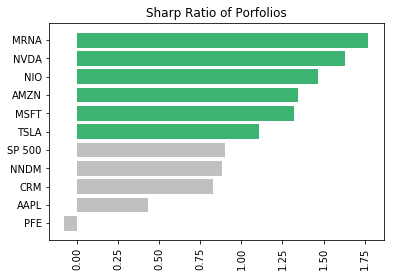

In [34]:
# Visualised Sharpe plot highlighing portfolios which are equal to the S&P.
# https://matplotlib.org/gallery/color/named_colors.html
values = sharpe_ratio.sort_values(ascending=True)   
SP = sharpe_ratio['SP 500']
clrs = ['silver' if (x <= SP) else 'mediumseagreen' for x in values]
plt.barh(np.array(list(values.index)), values, color=clrs)
plt.xticks(rotation=90)
plt.title('Sharp Ratio of Porfolios')
plt.show()

In [85]:
columns = ["MRNA", "SP 500"]
MRNA.hvplot.area(xticks=15) * SP_500.hvplot.line(xticks=15, color='red')

:Overlay
   .Area.MRNA    :Area   [Date]   (MRNA)
   .Curve.SP_500 :Curve   [Date]   (SP 500)

Text(0.5, 0, 'Date')

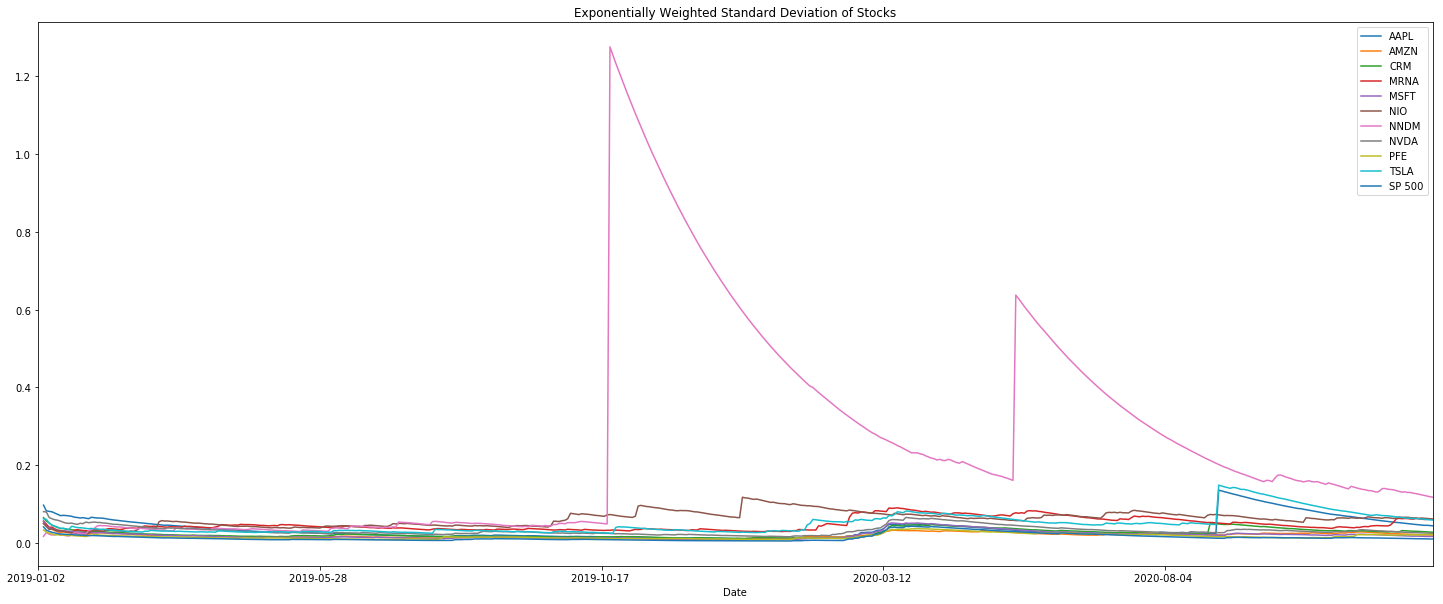

In [35]:
# Use `ewm` to calculate the rolling window
ewm_pf = daily_returns.ewm(span = 21)
df_daily_ewm = daily_returns.ewm(halflife=21 ,adjust = False).std()
df_daily_ewm.plot(figsize=(25, 10), title='Exponentially Weighted Standard Deviation of Stocks')
plt.xlabel('Date')

# std has a more meaningful takeaway, below it can be seen that the volatility comes unexpectedly and gradually fades away, 
# where as the means plot there is no significant takeaway

# Reports Dashboard

In [36]:
#### Statistical plots:
### Pie charts of top 10 foreign stocks sorted by market capand sector. Use drop-down pie chart to select martket cap or sector for the plots
### Interactive bar chart of same data?

In [37]:
#### Trend plots:
### Daily return trend of all stocks for two years
### Plot cumulative returns for all stocks for two years

In [38]:
#### Analyses results
### If these stocks form a portfolio, compare the correlations amongst them. What can we learn from this?
### Using FA output, plot of Analysts prediction versus actual performance of all stocks compared to SP 500 over the period
### Bar chart of top 10 stock overlayed by line plot of SP500? Are all these stocks in SP 500? 
### Gain(Loss) of total return vs SP 500

In [39]:
#### Observations and conclusion
## How do the 10 stocks perform vs the SP 500 in the 2 years analysed? Should these have been purchased?
## Are the analysts right?
## What are the likely drivers for the performance of these stocks?

In [40]:
#stock_data = fa.stock_data("AAPL", period="ytd", interval="1d")

In [41]:
#growth_annually = fa.financial_statement_growth("TSLA", fa_api_key, period="annual")

In [42]:
#ratings = fa.rating("MSFT", fa_api_key)

In [43]:
#stock_data_detailed = fa.stock_data_detailed("MSFT", fa_api_key, begin="2000-01-01", end="2001-01-01")

In [44]:
# Show the available companies
#companies = fa.available_companies(api_key)

# Collect general company information
#profile = fa.profile(ticker, api_key)

# Collect recent company quotes
#quotes = fa.quote(ticker, api_key)

# Collect market cap and enterprise value
#entreprise_value = fa.enterprise(ticker, api_key)

# Show recommendations of Analysts
#ratings = fa.rating(ticker, api_key)

# Obtain DCFs over time
#dcf_annually = fa.discounted_cash_flow(ticker, api_key, period="annual")
#dcf_quarterly = fa.discounted_cash_flow(ticker, api_key, period="quarter")

# Collect the Balance Sheet statements
#balance_sheet_annually = fa.balance_sheet_statement(ticker, api_key, period="annual")
#balance_sheet_quarterly = fa.balance_sheet_statement(ticker, api_key, period="quarter")

# Collect the Income Statements
#income_statement_annually = fa.income_statement(ticker, api_key, period="annual")
#income_statement_quarterly = fa.income_statement(ticker, api_key, period="quarter")

# Collect the Cash Flow Statements
#cash_flow_statement_annually = fa.cash_flow_statement(ticker, api_key, period="annual")
#cash_flow_statement_quarterly = fa.cash_flow_statement(ticker, api_key, period="quarter")

# Show Key Metrics
#key_metrics_annually = fa.key_metrics(ticker, api_key, period="annual")
###key_metrics_quarterly = fa.key_metrics(ticker, api_key, period="quarter")

# Show a large set of in-depth ratios
#financial_ratios_annually = fa.financial_ratios(ticker, api_key, period="annual")
#financial_ratios_quarterly = fa.financial_ratios(ticker, api_key, period="quarter")

# Show the growth of the company
#growth_annually = fa.financial_statement_growth(ticker, api_key, period="annual")
#growth_quarterly = fa.financial_statement_growth(ticker, api_key, period="quarter")

# Download general stock data
#stock_data = fa.stock_data(ticker, period="ytd", interval="1d")

# Download detailed stock data
#stock_data_detailed = fa.stock_data_detailed(ticker, api_key, begin="2000-01-01", end="2020-01-01")